In [1]:
import time as tm
import numpy as np

import matplotlib
matplotlib.rcParams['text.usetex'] = True

from scipy.special import comb
from scipy.misc import derivative
from scipy import integrate, interpolate

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.gridspec as gridspec
import utilities_simple as utilities
from chainconsumer import ChainConsumer

In [2]:
### Define all the constants 
c      = 299792.458           #km/s
GN     = 6.674e-11     #m^3/kg/s^2
Msolar = 1.989e30  # kg
Mpc    = 3.086e19     # km

cosmo_params = {
     'OmegaM' : 0.2999,
     'OmegaDE': 0.7,
     'OmegaR' : 1.e-4,
     'h'     : 0.7,
 }

#GW150914 parameters
m1   = 36       #solarmass
m2   = 29

Dl   = 410      #Mpc
zem  = 0.09

time = 2*365*24*3600    # time before merger in sec
tc   = 0
psic = 0

In [3]:
#Read in and interpolate LIGO and LISA PSDs.
ligo_asd    = np.genfromtxt('../data/lalsimulation_lib_LIGO-T1800545-v1-aLIGO_175Mpc.txt')
LISA_strain = np.loadtxt('../data/LISA_strain.txt')

ligo_interp = interpolate.interp1d(ligo_asd[:,0],ligo_asd[:,1])
lisa_interp = interpolate.interp1d(LISA_strain[:,0], LISA_strain[:,3])

In [229]:
def numerical_derivative(func, par, dx, conv=5e-2, factor=.5, verbose=False):
    
    ratio   = 1e8
    r_best  = 1e8
    dx_best = 0.
    
    while ratio > conv:
        d1    = derivative(func, par, dx=dx/2, order=5)
        d2    = derivative(func, par, dx=dx *2, order=5)
        
        ld1   = len(d1)
        prod  = d1 *d2
        
        d1    = d1[prod != 0]
        d2    = d2[prod != 0]
        
        r_vec = np.abs( (d1 -d2)/np.mean((d1, d2), axis=0) )
        
        if len(r_vec) < int(ld1/3):
            ratio = 1e6
        else:
            ratio = np.mean(r_vec)
        
        if ratio < r_best:
            dx_best = dx
            r_best  = ratio
        
        dx *= factor  
        
        if dx < 1e-15:
            #print(par, dx)
            #raise ValueError('No convergence')
            ratio = 1e-1 *conv
    
    print('Ratio best = %.2e for dx = %.2e' % (r_best, dx_best))
    return derivative(func, par, dx=dx_best, order=5)

Ratio best = 4.09e-02 for dx = 1.95e-03
[ 1.00000000e+00 -2.08764193e-07  4.98308436e-07  3.55311596e-07
 -1.41230329e-07 -3.54450171e-03 -1.48430489e-07  3.78631852e-07
  1.62832159e-07 -7.26039542e-08 -1.23667634e-04 -9.71441070e-08
  2.32874800e-07  6.39826918e-08 -3.12401408e-08 -1.17328119e-05
 -5.80412634e-08  7.44647312e-08  1.94597676e-08 -9.34902149e-09
 -1.42695424e-06 -3.10808661e-08 -8.45436579e-08  2.92319307e-09
 -6.40438425e-11 -1.48424216e-07 -1.44295629e-08 -2.33601537e-07
 -1.22174827e-09  2.21755301e-09 -1.01623219e-09 -5.47102973e-09
 -3.63773821e-07 -1.14500049e-09  1.59275015e-09  4.55016496e-09
 -1.50406041e-09 -4.67818115e-07 -4.11593166e-10  5.48955498e-10
  9.80583814e-10 -2.24229043e-10 -5.40250413e-07 -5.44466494e-11
  5.94189755e-11  4.44198597e-11 -6.78270994e-12 -5.77391117e-07
 -6.44434890e-13  4.87021424e-13  4.87793493e-13 -6.97267117e-13
 -5.77391121e-07 -6.78270994e-12  4.44079797e-11  5.94189755e-11
 -5.43722138e-11 -5.40250413e-07 -2.23970488e-10  

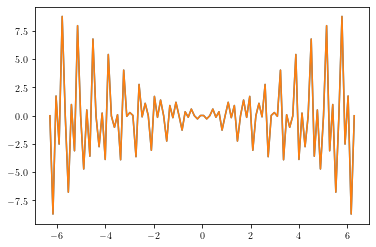

In [227]:
# Just a test of my function to compute derivatives
a_val    = 10
b_val    = 6
x        = np.linspace(-2 *np.pi, 2 * np.pi, 100)
my_func  = lambda a : np.sin(a * x)**b_val

analytic = b_val *x *np.cos(a_val *x) *np.sin(a_val * x)**(b_val -1)
dsin     = numerical_derivative(my_func, a_val, 1) 

plt.plot(x, dsin)
plt.plot(x, analytic)

print( (dsin -analytic ) / dsin )

In [176]:
# Define function to return covariance matrix for chosen waveform.

def Fisher_det(farr, pars, psd, cosmo_params, which_wf='GR', MG_flag=False, width=0, distcorr=True):
    t0 = tm.perf_counter()
    if which_wf=='GR':
        waveform = utilities.waveform
    elif which_wf=='EFT':
        waveform = utilities.waveform_delta(cT_type='EFT').h_Delta_exact
    elif which_wf=='step':
        waveform = utilities.waveform_delta(cT_type='step', width=width).h_Delta_exact
    
    if distcorr==False:
        hf = waveform(farr, pars, cosmo_params, distcorr=False)
    else:      
        hf = waveform(farr, pars, cosmo_params)
    
    # Function to compute numerical derivatives w.r.t. lnM
    h_dlnMz_to_der = lambda lnMz_func: waveform(farr, 
                    [lnMz_func, pars[1], pars[2], pars[3], pars[4], pars[5], pars[6]], cosmo_params) / hf

    # Function to compute numerical derivatives w.r.t. lneta
    h_dlneta_to_der = lambda lneta_func: waveform(farr, 
                    [pars[0], lneta_func, pars[2], pars[3], pars[4], pars[5], pars[6]], cosmo_params) / hf
        
    # Function to compute numerical derivatives w.r.t. lnz
    h_dlnz_to_der = lambda lnz_func: waveform(farr, 
                    [pars[0], pars[1], lnz_func, pars[3], pars[4], pars[5], pars[6]], cosmo_params) / hf
    
    # Function to compute numerical derivatives w.r.t. lnz
    h_dc0_to_der = lambda c0_func: waveform(farr, 
                    [pars[0], pars[1], pars[2], pars[3], pars[4], c0_func, pars[6]], cosmo_params) / hf
    
    # Analytical derivetives w.r.t. tc and psic
    dh_dtc      = 2.j*np.pi*farr*waveform(farr, pars, cosmo_params)
    dh_dpsic    = -1.j*waveform(farr, pars, cosmo_params)
    
    to_der      = [h_dlnMz_to_der, h_dlneta_to_der, h_dlnz_to_der, dh_dtc, dh_dpsic, h_dc0_to_der]
    derivatives = []
    verbose     = False
    
    for i in range(0, len(to_der)):
        print('- Working on index', i)
        dx = np.abs(.1 *pars[i]) if pars[i] != 0 else 1e-1
        
        if i == 3 or i == 4:
            derivatives.append(to_der[i])
        elif i == 5:
            if MG_flag:
                derivatives.append(numerical_derivative(to_der[i], pars[i], dx=dx) * hf)
                
        else:
            if i == 1 or i ==2:
                dx = 1e-1
            elif i ==1:
                dx = 1e-5            
            derivatives.append(numerical_derivative(to_der[i], pars[i], dx=dx, verbose=verbose) *hf)
    
    print('Here I start computing fishers')
    derivatives   = derivatives[:2][::-1] + derivatives[2:]
    Fisher_matrix = np.zeros((len(derivatives),len(derivatives)))

    for i in range(0, len(derivatives)):
        for j in range(0,i +1):
            Fisher_matrix[i,j] = utilities.scalar_product(derivatives[i], derivatives[j], psd, farr)
            Fisher_matrix[j,i] = Fisher_matrix[i,j]
    
    print('This took %.2f seconds' % (tm.perf_counter() -t0) )
    connum = np.linalg.cond(Fisher_matrix)
    print('condition number (div by 1e15)',connum/1.e15)

    return derivatives, Fisher_matrix

In [153]:
# Get mass quantities
m_eff = m1*m2/(m1+m2)
Ms = m_eff**(3./5) * (m1+m2)**(2./5)     # source chirp mass in solarmass
eta = ((m1+m2)/Ms)**(-5./3)

Dl_s = Dl*Mpc/c        # Dl in sec

Ms_s = Ms * Msolar * GN / (c*1.e3)**3.       # source chirp mass in sec
Mtot_s = (m1+m2) * Msolar * GN / (c*1.e3)**3.

# Get frequency ranges for inspiral and plots
f_start = (5*Ms_s/256/time)**(3./8) / np.pi/Ms_s      # starting frequency at the time before merger
f_cut = utilities.get_freq(Mtot_s, eta, "cut")       # End of IMR template
fc = utilities.inspiral_fc(Mtot_s)
farr = np.logspace(np.log10(f_start),np.log10(fc),num=500)  #inspiral range only
f_plot = np.logspace(np.log10(f_start),np.log10(f_cut),num=500)     # full IMR waveform

Dl_arr = np.array([Dl_s]*len(farr))

In [154]:
print('eta',eta)
print('fc',fc)

eta 0.24710059171597634
fc 67.63181124855085


In [155]:
#Waveforms for inspiral and IMR, in GR
pars_GR = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, 0, 0]

h_GR = utilities.waveform(farr, pars_GR, cosmo_params)
h_plot = utilities.waveform(f_plot, pars_GR, cosmo_params)

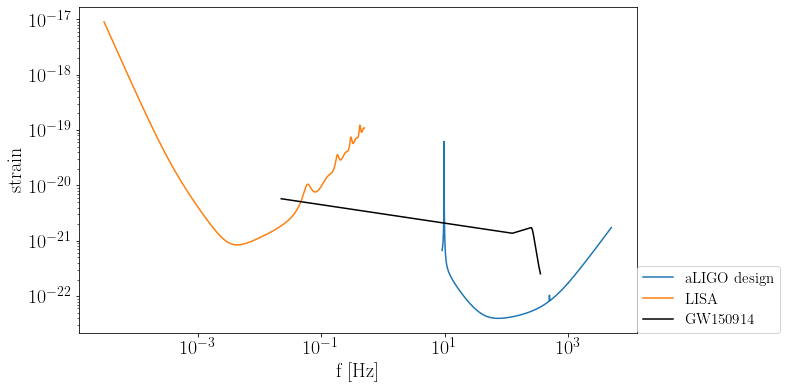

In [156]:
# Plot full IMR GR signal
plt.figure(figsize=(10,6))
plt.loglog(ligo_asd[:,0],np.sqrt(ligo_asd[:,0])*ligo_asd[:,1],label='aLIGO design')
plt.loglog(LISA_strain[:,0],np.sqrt(LISA_strain[:,0]*LISA_strain[:,3]),label='LISA')
plt.loglog(f_plot, np.abs(f_plot*h_plot), color='k', label='GW150914')
plt.xlabel('f [Hz]', fontsize=20)
plt.ylabel('strain', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15, loc=(1,0))

In [157]:
# Get waveform segments in LISA and LIGO ranges only.
farr_ligo = np.logspace(np.log10(ligo_asd[0,0]),np.log10(fc),num=500)
farr_lisa = np.logspace(np.log10(f_start),np.log10(LISA_strain[-1,0]),num=500)

ligo_psd = ligo_interp(farr_ligo)**2
lisa_psd = lisa_interp(farr_lisa)

h_GR_ligo = utilities.waveform(farr_ligo, pars_GR, cosmo_params)
h_GR_lisa = utilities.waveform(farr_lisa, pars_GR, cosmo_params)


In [158]:
# SNR in LISA and LIGO
SNR_ligo_sq = utilities.scalar_product(h_GR_ligo, h_GR_ligo, ligo_psd, farr_ligo)
SNR_ligo = np.sqrt(SNR_ligo_sq)

SNR_lisa_sq = utilities.scalar_product(h_GR_lisa, h_GR_lisa, lisa_psd, farr_lisa)
SNR_lisa = np.sqrt(SNR_lisa_sq)

print('design LIGO SNR')
print(SNR_ligo)
print('LISA SNR')
print(SNR_lisa)

design LIGO SNR
65.53220995174958
LISA SNR
3.4325121616962133


# GR Constraints

In [212]:
ders_ligo, fisher_ligo = Fisher_det(farr_ligo, pars_GR, ligo_psd, cosmo_params, which_wf='GR')
cov_matrix_ligo = np.linalg.inv(fisher_ligo)
pconstraints_ligo = np.sqrt(np.diag(cov_matrix_ligo))

print('LIGO GR constraints')
print(pconstraints_ligo)

- Working on index 0
Ratio best = 4.49e-03 for dx = 3.34e-04
- Working on index 1
Ratio best = 1.17e-06 for dx = 1.00e-06
- Working on index 2
Ratio best = 2.70e-02 for dx = 1.00e-01
- Working on index 3
- Working on index 4
- Working on index 5
Here I start computing fishers
This took 8.75 seconds
condition number (div by 1e15) 1.3549735875058841e-08
LIGO GR constraints
[0.01955089 0.00265579 0.01452998 0.00056156 0.20065736]


In [213]:
fisher_ligo

array([[ 3.37797783e+05, -1.59753703e+06, -4.81856179e-08,
         4.02239118e+06, -2.41308532e+04],
       [-1.59753703e+06,  8.05748708e+06, -3.79777254e+03,
        -1.42931655e+07,  9.55904286e+04],
       [-4.81856179e-08, -3.79777254e+03,  4.83626938e+03,
        -2.12511706e-11,  5.23935443e-14],
       [ 4.02239118e+06, -1.42931655e+07, -2.12511706e-11,
         3.33114490e+08, -1.13124342e+06],
       [-2.41308532e+04,  9.55904286e+04,  5.23935443e-14,
        -1.13124342e+06,  4.29447054e+03]])

In [209]:
ders_lisa, fisher_lisa = Fisher_det(farr_lisa, pars_GR, lisa_psd, cosmo_params, which_wf='GR') 
cov_matrix_lisa = np.linalg.inv(fisher_lisa)
pconstraints_lisa = np.sqrt(np.diag(cov_matrix_lisa))

print('LISA GR constraints')
print(pconstraints_lisa)

- Working on index 0
Ratio best = 1.32e-04 for dx = 3.34e-09
- Working on index 1


/tmp/ipykernel_31506/2739671101.py:17: RuntimeWarning: divide by zero encountered in true_divide
  r_vec = np.abs( (d1 -d2)/np.mean((d1, d2), axis=0) )
/tmp/ipykernel_31506/2739671101.py:17: RuntimeWarning: invalid value encountered in true_divide
  r_vec = np.abs( (d1 -d2)/np.mean((d1, d2), axis=0) )


Ratio best = 2.16e-01 for dx = 1.00e-04
- Working on index 2
Ratio best = 2.70e-02 for dx = 1.00e-01
- Working on index 3
- Working on index 4
- Working on index 5
Here I start computing fishers
This took 16.96 seconds
condition number (div by 1e15) 10.314560340620256
LISA GR constraints
[4.84853851e-02 7.36248349e-06 2.74528532e-01 3.65763883e+00
 4.49519583e+00]


In [210]:
fisher_lisa

array([[ 7.95710073e+06,  5.73286137e+10, -7.96034906e-04,
        -1.56153878e+03,  8.91772740e+03],
       [ 5.73286137e+10,  4.13575921e+14, -1.04864188e+01,
        -1.16500090e+07,  6.52148389e+07],
       [-7.96034906e-04, -1.04864188e+01,  1.32685976e+01,
         1.05175451e-16, -5.85365313e-16],
       [-1.56153878e+03, -1.16500090e+07,  1.05175451e-16,
         6.95922276e-01, -2.49879922e+00],
       [ 8.91772740e+03,  6.52148389e+07, -5.85365313e-16,
        -2.49879922e+00,  1.17821397e+01]])

In [211]:
label_GR = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta z/z$',r'$t_c$',r'$\Psi_c$']
fid_vals_GR = [0,0,0,0,0]

data_ligo = np.random.multivariate_normal(fid_vals_GR, cov_matrix_ligo, size=10000)
data_lisa = np.random.multivariate_normal(fid_vals_GR, cov_matrix_lisa, size=10000)

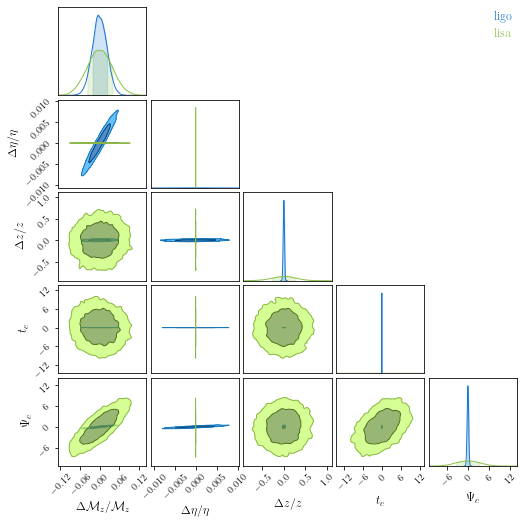

In [86]:
cc = ChainConsumer()
cc.add_chain(data_ligo, bins=30, smooth=True, parameters=label_GR, name='ligo');
cc.add_chain(data_lisa, bins=30, smooth=True, parameters=label_GR,name='lisa');
cc.plotter.plot();

# Step function

In [230]:
# Set parameters for step
fstar = 0.8
c0 = 0.9
w1 = 0.5

In [160]:
# Evaluate and plot Delta
cT_step_fo_w1 = utilities.cT_step(farr, fstar, c0, w1)
cT_step_fs_w1 = utilities.cT_step(farr*(1+zem), fstar, c0, w1)
Delta_step_w1 = 1-cT_step_fo_w1/cT_step_fs_w1

Text(0, 0.5, '$\\Delta$')

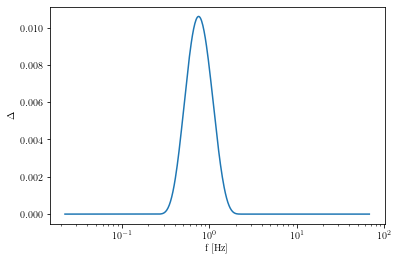

In [161]:
plt.semilogx(farr, Delta_step_w1)
plt.xlabel('f [Hz]')
plt.ylabel(r'$\Delta$')

In [162]:
# Set parameters for runs and evaluate
pars_step = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, c0, fstar]
pars_step_fid = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, 1., fstar]

# For plotting only
h_Delta_step_w1 = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr, pars_step, cosmo_params)
h_Delta_step_w1_fid = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr, pars_step_fid, cosmo_params)
h_Delta_step_w1_fid_nodist = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr, pars_step_fid, cosmo_params,dist_corr=False)

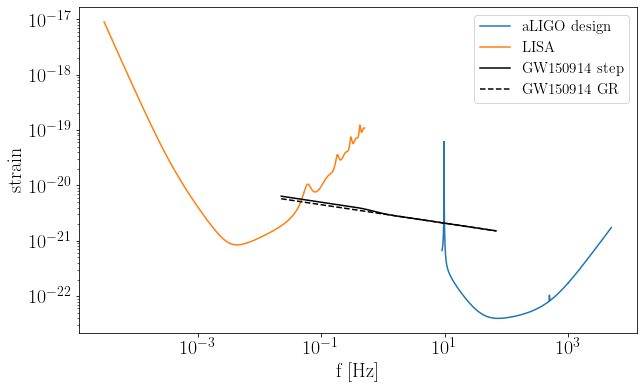

In [163]:
plt.figure(figsize=(10,6))
plt.loglog(ligo_asd[:,0],np.sqrt(ligo_asd[:,0])*ligo_asd[:,1],label='aLIGO design')
plt.loglog(LISA_strain[:,0],np.sqrt(LISA_strain[:,0]*LISA_strain[:,3]),label='LISA')
plt.loglog(farr, np.abs(farr*h_Delta_step_w1), color='k', label='GW150914 step')
plt.loglog(farr, np.abs(farr*h_GR), color='k', label='GW150914 GR', linestyle='--')
plt.xlabel('f [Hz]', fontsize=20)
plt.ylabel('strain', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
# plt.savefig('../plots/amp_psd_step.pdf')

In [208]:
#mask_ligo = (farr>ligo_asd[0,0]) & (farr<=ligo_asd[-1,0])
#mask_lisa = (farr>LISA_strain[0,0]) & (farr<=LISA_strain[-1,0])

#ligo_psd = ligo_interp(farr[mask_ligo])**2
#lisa_psd = lisa_interp(farr[mask_lisa])

In [168]:
# SNR for fiducial and non-fiducial models
SNR_ligo_sq = utilities.scalar_product(h_Delta_step_w1, h_Delta_step_w1, ligo_psd, farr)
SNR_ligo_sq_fid = utilities.scalar_product(h_Delta_step_w1_fid, h_Delta_step_w1_fid, ligo_psd, farr)
SNR_ligo_step = np.sqrt(SNR_ligo_sq)
SNR_ligo_step_fid = np.sqrt(SNR_ligo_sq_fid)

SNR_lisa_sq = utilities.scalar_product(h_Delta_step_w1, h_Delta_step_w1, lisa_psd, farr)
SNR_lisa_sq_fid = utilities.scalar_product(h_Delta_step_w1_fid, h_Delta_step_w1_fid, lisa_psd, farr)
SNR_lisa_step = np.sqrt(SNR_lisa_sq)
SNR_lisa_step_fid = np.sqrt(SNR_lisa_sq_fid)

print('LIGO SNR, mod and fiducial')
print(SNR_ligo_step,SNR_ligo_step_fid)
print('LISA SNR, mod and fiducial')
print(SNR_lisa_step,SNR_lisa_step_fid)

LIGO SNR, mod and fiducial
917.2496813188234 849.0554053863166
LISA SNR, mod and fiducial
4.670978855472421 4.204695910833687


In [203]:
# Constraints for fiducial and non-fiducial models
ders_lisa_step_distcorr, fisher_lisa_step_distcorr = Fisher_det(farr, pars_step, lisa_psd, cosmo_params, which_wf='step', MG_flag=True, width=w1, distcorr=True)
cov_matrix_lisa_step_distcorr = np.linalg.inv(fisher_lisa_step_distcorr)

ders_lisa_step, fisher_lisa_step = Fisher_det(farr, pars_step, lisa_psd, cosmo_params, which_wf='step', MG_flag=True, width=w1, distcorr=False)
cov_matrix_lisa_step = np.linalg.inv(fisher_lisa_step)

ders_lisa_step_fid, fisher_lisa_step_fid = Fisher_det(farr, pars_step_fid, lisa_psd, cosmo_params, which_wf='step', MG_flag=True, width=w1, distcorr=True)
cov_matrix_lisa_step_fid = np.linalg.inv(fisher_lisa_step_fid)

ders_lisa_step_fid_distcorr, fisher_lisa_step_fid_distcorr = Fisher_det(farr, pars_step_fid, lisa_psd, cosmo_params, which_wf='step', MG_flag=True, width=w1, distcorr=False)
cov_matrix_lisa_step_fid_distcorr = np.linalg.inv(fisher_lisa_step_fid_distcorr)

pconstraints_lisa_step = np.sqrt(np.diag(cov_matrix_lisa_step))
pconstraints_lisa_step_fid = np.sqrt(np.diag(cov_matrix_lisa_step_fid))
pconstraints_lisa_step_distcorr = np.sqrt(np.diag(cov_matrix_lisa_step_distcorr))
pconstraints_lisa_step_fid_distcorr = np.sqrt(np.diag(cov_matrix_lisa_step_fid_distcorr))

print('LISA step function')
print('mod')
print(pconstraints_lisa_step)
print('mod with distcorr')
print(pconstraints_lisa_step_distcorr)
print('fiducial')
print(pconstraints_lisa_step_fid)
print('fiducial with dist corr')
print(pconstraints_lisa_step_fid_distcorr)


- Working on index 0
Ratio best = 4.32e-03 for dx = 3.34e-11
- Working on index 1
Ratio best = 2.69e+02 for dx = 1.00e-07
- Working on index 2
Ratio best = 4.87e+02 for dx = 1.00e-02
- Working on index 3
- Working on index 4
- Working on index 5
Ratio best = 7.66e+02 for dx = 9.00e-06
Here I start computing fishers
This took 126.29 seconds
condition number (div by 1e15) 8.740925606466602e-05
- Working on index 0


KeyboardInterrupt: 

In [204]:
np.array(ders_lisa_step_distcorr)[2]

array([ 1.94476340e-17-2.95109021e-17j,  3.32535200e-18+4.74547336e-18j,
        2.98345093e-18-3.78178210e-17j, -1.02443400e-17+1.98730123e-17j,
        1.35059259e-17+2.46433974e-17j,  1.28845702e-17-6.58608294e-18j,
       -2.53901523e-17+7.61784672e-18j, -5.23859189e-18-2.23172538e-17j,
        3.42764535e-17-7.73508148e-18j, -1.44206094e-18-2.32763414e-19j,
       -1.92828286e-17-2.08897963e-17j,  2.89126965e-17+5.85901062e-18j,
        2.69076735e-17-1.13713322e-17j, -2.12083567e-18-9.90718552e-18j,
       -1.69308741e-17+9.53873520e-19j,  1.67920610e-18+2.57555542e-17j,
        1.26684212e-17-1.96721756e-17j,  2.23913618e-17+6.41059019e-18j,
        7.97491156e-18+6.08633925e-18j, -6.24088694e-18-5.88156996e-18j,
        2.30527000e-17-1.24979411e-17j, -1.55985388e-17+1.47498110e-17j,
       -2.07568250e-19-1.05609443e-18j, -1.70395917e-17+1.47385256e-17j,
       -9.28235086e-18-2.11814175e-17j, -2.54393347e-18-2.58832458e-18j,
       -1.76534797e-17-4.05462943e-18j, -1.91342880

In [205]:
wf = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact

def to_der(par):
    ppars = np.array(pars_step)
    ppars[0] = par
    return wf(farr, ppars, cosmo_params, dist_corr=True)#

dM = numerical_derivative(to_der, pars_step[0], 1e-1)

Ratio best = 1.38e-02 for dx = 1.00e-11


In [206]:
( dM -np.array(ders_lisa_step_distcorr)[0] ) / dM

array([1.        -4.22717223e-16j, 1.        -7.62461726e-17j,
       1.        +1.53512432e-16j, 1.        -1.51911709e-15j,
       1.        -9.06011849e-16j, 1.        -1.95794742e-15j,
       1.        +4.74213407e-15j, 1.        -1.65408564e-16j,
       1.        +1.28084921e-15j, 1.        +3.15159746e-15j,
       1.        +6.15019133e-16j, 1.        -6.00785200e-16j,
       1.        +1.20220916e-16j, 1.        -2.71029263e-15j,
       1.        -4.26166149e-15j, 1.        -1.69689288e-15j,
       1.        -2.62657548e-16j, 1.        +8.08671248e-16j,
       1.        +3.12691976e-15j, 1.        +1.13391792e-15j,
       1.        +1.16515270e-15j, 1.        -1.37278881e-16j,
       1.        -6.76214064e-17j, 1.        -3.41255742e-15j,
       1.        -1.66303624e-15j, 1.        -1.85887003e-16j,
       1.        +5.27573266e-16j, 1.        +5.73564462e-15j,
       1.        -1.92095872e-16j, 1.        -5.05763830e-16j,
       1.        -3.93353139e-16j, 1.        -4.4890808

In [ ]:
# Now fix tc to ms accuracy
Fisher_matrix_lisa_step_fid = np.linalg.inv(cov_matrix_lisa_step_fid)
Fisher_matrix_lisa_step_fid_fixtc = np.array(Fisher_matrix_lisa_step_fid)
Fisher_matrix_lisa_step_fid_fixtc[3,3] = 1.e6
cov_matrix_lisa_step_fid_fixtc = np.linalg.inv(Fisher_matrix_lisa_step_fid_fixtc)

In [ ]:
# Now fix tc to ms accuracy
Fisher_matrix_lisa_step = np.linalg.inv(cov_matrix_lisa_step)
Fisher_matrix_lisa_step_fixtc = np.array(Fisher_matrix_lisa_step)
Fisher_matrix_lisa_step_fixtc[3,3] = 1.e6
cov_matrix_lisa_step_fixtc = np.linalg.inv(Fisher_matrix_lisa_step_fixtc)

In [ ]:
# Same for uncorrected version
Fisher_matrix_lisa_step_fid_distcorr = np.linalg.inv(cov_matrix_lisa_step_fid_distcorr)
Fisher_matrix_lisa_step_fid_distcorr_fixtc = np.array(Fisher_matrix_lisa_step_fid_distcorr)
Fisher_matrix_lisa_step_fid_distcorr_fixtc[3,3] = 1.e6
cov_matrix_lisa_step_fid_distcorr_fixtc = np.linalg.inv(Fisher_matrix_lisa_step_fid_distcorr_fixtc)

In [151]:
label = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta z/z$',r'$t_c$',r'$\Psi_c$', 'c0']
fid_vals = [0,0,0,0,0,1]
fid_vals_MG = [0,0,0,0,0,c0]

data = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid, size=20000)
data_fixtc = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid_fixtc, size=20000)
data_distcorr = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid_distcorr, size=20000)
data_distcorr_fixtc = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid_distcorr_fixtc, size=20000)
data_MG = np.random.multivariate_normal(fid_vals_MG, cov_matrix_lisa_step, size=20000)
data_MG_fixtc = np.random.multivariate_normal(fid_vals_MG, cov_matrix_lisa_step_fixtc, size=20000)


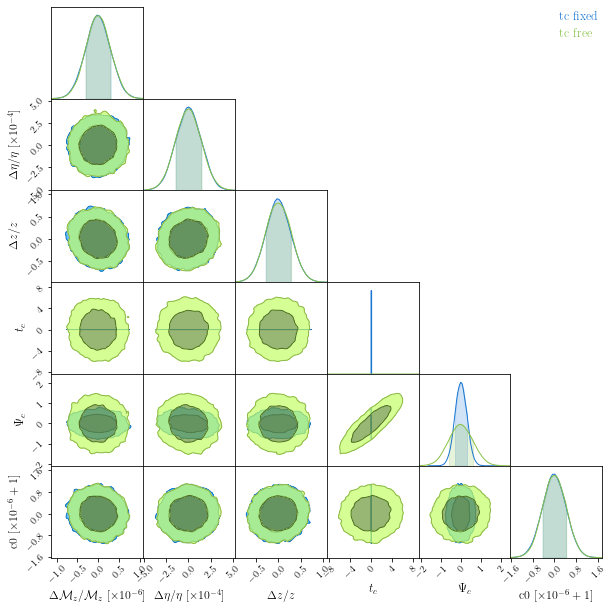

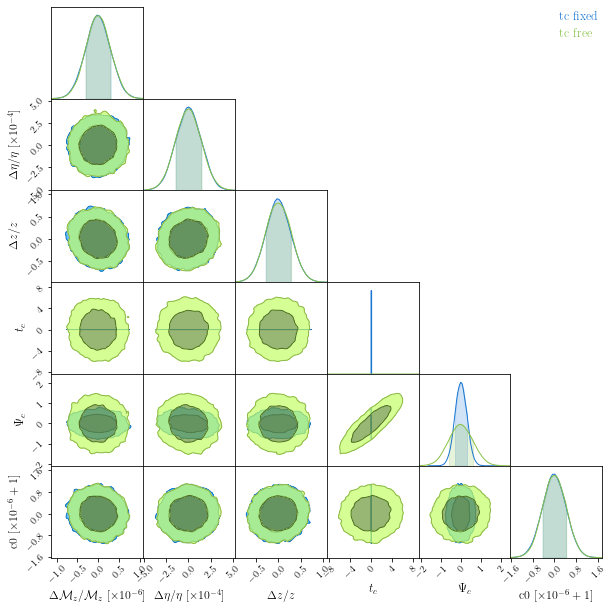

In [142]:
cc = ChainConsumer()
cc.add_chain(data_fixtc, bins=30, smooth=True, parameters=label,name='tc fixed');
cc.add_chain(data, bins=30, smooth=True, parameters=label, name='tc free');
cc.plotter.plot();


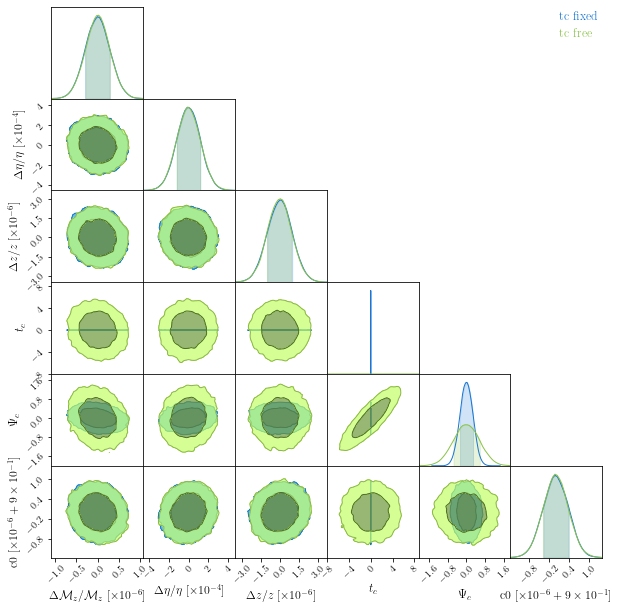

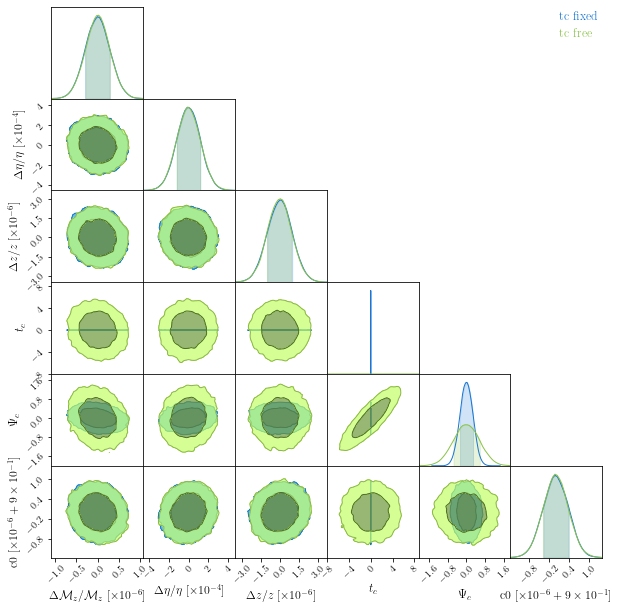

In [152]:
cc = ChainConsumer()
cc.add_chain(data_MG_fixtc, bins=30, smooth=True, parameters=label,name='tc fixed');
cc.add_chain(data_MG, bins=30, smooth=True, parameters=label, name='tc free');
cc.plotter.plot();

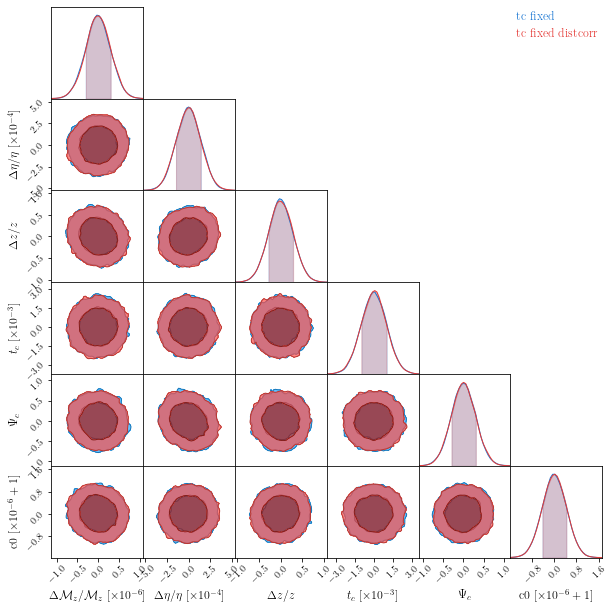

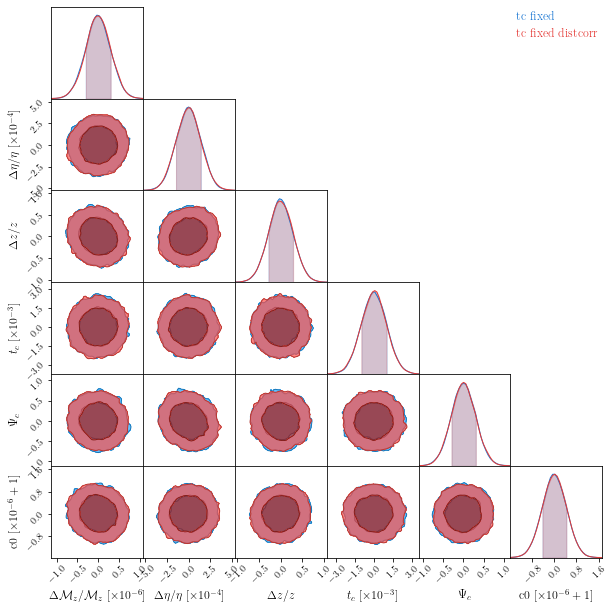

In [143]:
cc = ChainConsumer()

#cc.add_chain(data_fixtc, bins=30, smooth=True, parameters=label, name='tc fixed')
cc.add_chain(data_distcorr_fixtc, bins=30, smooth=True, parameters=label,name='tc fixed distcorr',color='r');
cc.plotter.plot();

In [144]:
Psi, Psi_old = utilities.Psi_Delta_exact(farr, fstar, c0, Ms, eta, zem, cosmo_params, tc, psic, cT_type='step', width=w1)

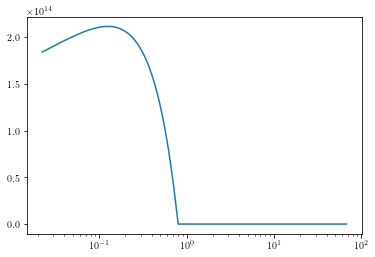

In [145]:
plt.semilogx(farr,abs(Psi/Psi_old))

In [127]:
cc.remove_chain('tc fixed')
cc.remove_chain('tc fixed distcorr')